In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

# Track data loading
import psutil
import time

# Save&Load results
import pickle

In [102]:
import sys, os
print(sys.version)

3.8.13 (default, Mar 28 2022, 11:38:47) 
[GCC 7.5.0]


In [3]:
nx.__version__

'2.8.8'

In [4]:
## Get CPU information
cpu_count = psutil.cpu_count(logical=False)
cpu_freq = psutil.cpu_freq().current
cpu_total_size = psutil.virtual_memory().total / (1024**3)

# Get RAM information
total_ram = psutil.virtual_memory().total / (1024 ** 3)

## Print
print(f"CPU count: {cpu_count}")
print(f"CPU frequency: {cpu_freq} GHz")
print(f"CPU total size: {cpu_total_size:.2f} GB")
print(f"Total RAM: {total_ram:.2f} GB")

CPU count: 40
CPU frequency: 3239.365525 GHz
CPU total size: 375.90 GB
Total RAM: 375.90 GB


In [5]:
# Parallel Programming
import multiprocessing
from functools import partial
import time
from p_tqdm import p_map

# 1. Load Data

In [6]:
global G_original

st = time.time()

with open("data/graphs/G_original_unattributed.gpickle", 'rb') as f:
    G_original = pickle.load(f)

et = time.time()
elapsed_time = et - st

In [7]:
print('Execution time:', elapsed_time/60, 'mins')
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

Execution time: 2.337152091662089 mins
RAM memory % used: 10.5
RAM Used (GB): 39.905046528


# 2. Disparity Filter

Due to the large size of our dataset, we code the disparity filter algorithm ([Serrano et al., 2009](https://doi.org/10.1073/pnas.0808904106)) using parallel programming, where we evaluate the statistical significance of each node in parallel.

There are various alternative ways to implement the disparity filter algorithm. For instance, one may consider the operation of matrics (i.e., the adjacency matrix of a graph), and compute the statistical significance of all nodes at once. 
This approach is implemented in an R package, [CRAN](https://github.com/zpneal/backbone/blob/release/man/disparity.Rd), developed by Neal.
However, for this method, our computing resources, specifically the RAM (almost 400GB in our case), are not sufficient to handle our dataset, a 2GB unattributed directed graph. The adjacency matrix for this graph, which contains 13.9 million nodes (i.e., 13.9M x 13.9M), is simply too large to process.


Below, we present the code implementation from scratch, so it’s easier to follow what happens at each step. Further optimisation and wrapping could be done, but that’s not our main focus here.


In [9]:
def disparity_directed_network_edge(edge):
    
    # wij_in (in terms of flowing to j) and wij_out (in terms of flowing out of i) are of the same value
    wij = G_original.edges[edge]['weight']
    
    # k_in, k_out
    k_out = G_original.out_degree(edge[0]) # in terms of flowing out of i
    k_in = G_original.in_degree(edge[1])   # in terms of flowing to j
    
    # normalised weight
    pij_out = wij/G_original.out_degree(edge[0], weight = "weight") # in terms of flowing out of i
    pij_in = wij/G_original.in_degree(edge[1], weight = "weight")   # in terms of flowing to j
    
    # alpha_ij
    alpha_ij_out = 1
    alpha_ij_in = 1
    if k_out > 1: 
        alpha_ij_out = (1 - pij_out)**(k_out - 1) # in terms of flowing out of i
    if k_in > 1:
        alpha_ij_in = (1 - pij_in)**(k_in - 1)   # in terms of flowing to j
    
    return (edge, [pij_out, pij_in, alpha_ij_out, alpha_ij_in]) # parallel programming may mess up the correspondency

In [10]:
def split_list(lst, parts = 10):
    size = len(lst) // parts
    remainder = len(lst) % parts
    start = 0

    for i in range(parts):
        end = start + size + (1 if i < remainder else 0)
        yield lst[start:end]
        start = end

In [11]:
def disparity_directed_network(edge_list, save_address):
    
    st = time.time()
    
    alpha_ij_dict = dict(p_map(disparity_directed_network_edge, edge_list))
    
    et = time.time()
    elapsed_time = et - st

    print('Execution time:', elapsed_time/60, 'mins')
    # Getting % usage of virtual_memory ( 3rd field)
    print('RAM memory % used:', psutil.virtual_memory()[2])
    # Getting usage of virtual_memory in GB ( 4th field)
    print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
    
    with open(save_address, 'wb') as pickle_file:
        pickle.dump(alpha_ij_dict, pickle_file)

In [12]:
# Separate a list of all edges into ten, and run code seperately to save RAM
separate_edge_list = list(split_list(list(G_real.edges), 10))

In [13]:
for i in range(10):
    save_address = 'results/alpha_ij_dict' + str(i) + '.pkl'
    disparity_directed_network(separate_edge_list[i], save_address)

  0%|          | 0/7233174 [00:00<?, ?it/s]

- Load Results

In [12]:
results_dict = {}

for i in range(10):
    
    print("Document " + str(i))
    st = time.time()
    
    save_address = 'results/alpha_ij_dict' + str(i) + '.pkl'
    with open(save_address, 'rb') as pickle_file:
        results_dict.update(pickle.load(pickle_file))
    
    et = time.time()
    elapsed_time = et - st

    print('Execution time:', elapsed_time/60, 'mins')
    # Getting % usage of virtual_memory ( 3rd field)
    print('RAM memory % used:', psutil.virtual_memory()[2])
    # Getting usage of virtual_memory in GB ( 4th field)
    print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
    print("==========")

Document 0
Execution time: 0.737782351175944 mins
RAM memory % used: 11.1
RAM Used (GB): 41.94881536
Document 1
Execution time: 0.5852374315261841 mins
RAM memory % used: 11.9
RAM Used (GB): 45.247434752
Document 2
Execution time: 0.6039429585138957 mins
RAM memory % used: 12.6
RAM Used (GB): 48.24758272
Document 3
Execution time: 0.6799239635467529 mins
RAM memory % used: 13.5
RAM Used (GB): 51.632615424
Document 4
Execution time: 0.7363367199897766 mins
RAM memory % used: 14.1
RAM Used (GB): 54.176927744
Document 5
Execution time: 0.2553036053975423 mins
RAM memory % used: 14.9
RAM Used (GB): 57.339527168
Document 6
Execution time: 0.874437149365743 mins
RAM memory % used: 15.9
RAM Used (GB): 61.638057984
Document 7
Execution time: 0.2710241993268331 mins
RAM memory % used: 16.7
RAM Used (GB): 64.583282688
Document 8
Execution time: 0.991660722096761 mins
RAM memory % used: 17.3
RAM Used (GB): 66.919661568
Document 9
Execution time: 0.2517377575238546 mins
RAM memory % used: 18.0
RAM

In [13]:
print(results_dict[(0, 5854705)])

[1.0, 9.416107192964285e-06, 1, 0.6423480201386113]


# 3. Check Heterogeneity (Assumption)

We check assumptions for implementing the disparity filter following [Serrano et al., 2009](https://doi.org/10.1073/pnas.0808904106). Note that the code here is independent of the disparity filter algorithm itself.

In [14]:
def heterogeneity_directed_network_node(node):
    
    gamma_out = 0
    gamma_in = 0
 
    # k_in, k_out
    k_out = G_real.out_degree(node) 
    k_in = G_real.in_degree(node)
    
    if k_out > 0:
        pij_out_arr = np.array([results_dict[edge][0] for edge in list(G_real.out_edges(node))])
        pij_out_ss = np.dot(pij_out_arr, pij_out_arr)      # sum of squares
        gamma_out = k_out * pij_out_ss
    
    if k_in > 0:
        pij_in_arr = np.array([results_dict[edge][1] for edge in list(G_real.in_edges(node))])
        pij_in_ss = np.dot(pij_in_arr, pij_in_arr)        # sum of squares
        gamma_in = k_in * pij_in_ss
    
    return (node, [k_out, k_in, gamma_out, gamma_in])

In [15]:
def heterogeneity_directed_network(node_list, save_address):
    
    st = time.time()
    
    gamma_node_dict = dict(p_map(heterogeneity_directed_network_node, node_list))
    
    et = time.time()
    elapsed_time = et - st

    print('Execution time:', elapsed_time/60, 'mins')
    # Getting % usage of virtual_memory ( 3rd field)
    print('RAM memory % used:', psutil.virtual_memory()[2])
    # Getting usage of virtual_memory in GB ( 4th field)
    print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
    
    with open(save_address, 'wb') as pickle_file:
        pickle.dump(gamma_node_dict, pickle_file)

In [17]:
# Separate a list of all nodes into ten, and run code seperately to save RAM
separate_node_list = list(split_list(list(G_original.nodes), 10))

In [ ]:
for i in range(10):
    save_address = 'results/gamma_node_dict' + str(i) + '.pkl'
    heterogeneity_directed_network(separate_node_list[i], save_address)

  0%|          | 0/1394816 [00:00<?, ?it/s]

Execution time: 27.530245077610015 mins
RAM memory % used: 17.8
RAM Used (GB): 68.81923072


  0%|          | 0/1394816 [00:00<?, ?it/s]

- Load Results

In [19]:
results_dict2 = {}

for i in range(10):
    
    print("Document " + str(i))
    st = time.time()
    
    save_address = 'results/gamma_node_dict' + str(i) + '.pkl'
    with open(save_address, 'rb') as pickle_file:
        results_dict2.update(pickle.load(pickle_file))
    
    et = time.time()
    elapsed_time = et - st

    print('Execution time:', elapsed_time/60, 'mins')
    # Getting % usage of virtual_memory ( 3rd field)
    print('RAM memory % used:', psutil.virtual_memory()[2])
    # Getting usage of virtual_memory in GB ( 4th field)
    print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
    print("==========")

Document 0
Execution time: 0.04663885434468587 mins
RAM memory % used: 18.0
RAM Used (GB): 69.847883776
Document 1
Execution time: 0.051497987906138104 mins
RAM memory % used: 18.0
RAM Used (GB): 69.91443968
Document 2
Execution time: 0.04784161647160848 mins
RAM memory % used: 18.1
RAM Used (GB): 70.189981696
Document 3
Execution time: 0.04462676048278809 mins
RAM memory % used: 18.1
RAM Used (GB): 70.471385088
Document 4
Execution time: 0.0447162389755249 mins
RAM memory % used: 18.2
RAM Used (GB): 70.749761536
Document 5
Execution time: 0.04169205824534098 mins
RAM memory % used: 18.2
RAM Used (GB): 70.858186752
Document 6
Execution time: 0.04243693351745605 mins
RAM memory % used: 18.3
RAM Used (GB): 71.136673792
Document 7
Execution time: 0.9783863623936971 mins
RAM memory % used: 18.4
RAM Used (GB): 71.413444608
Document 8
Execution time: 0.04734218120574951 mins
RAM memory % used: 18.6
RAM Used (GB): 72.230617088
Document 9
Execution time: 0.04184372027715047 mins
RAM memory % u

- Plot

In [20]:
results_values_arr = np.array(list(results_dict2.values()))

k_out_arr = results_values_arr[:, 0]; k_in_arr = results_values_arr[:, 1]
gamma_out_arr = results_values_arr[:, 2]; gamma_in_arr = results_values_arr[:, 3]

mask_out = (k_out_arr > 0); mask_in = (k_in_arr > 0)

In [21]:
def null_model(k):
    mean = 2*k / (k+1)
    sigma = np.sqrt(k**2 * ((20+4*k)/((k+1)*(k+2)*(k+3)) - 4/(k+1)**2)) 
    
    y = mean + 2*sigma
    
    return y

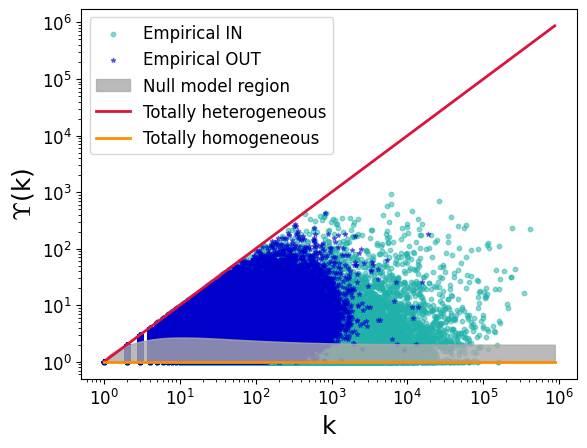

In [57]:
fig = plt.figure()

# Empirical situation
plt.scatter(k_in_arr[mask_in], gamma_in_arr[mask_in], label = "Empirical IN", c = 'lightseagreen', marker = 'o', s = 10, alpha = 0.5)
plt.scatter(k_out_arr[mask_out], gamma_out_arr[mask_out], label = "Empirical OUT", c = 'mediumblue', marker = '*', s = 10, alpha = 0.5)

# Null model
x = np.array([10**(6*i/100) for i in range(100)])
y = null_model(x)
plt.fill_between(x, 1, y, color = 'darkgray', alpha = 0.8, label = 'Null model region')

# Baseline
plt.plot(x, x, c = 'crimson', label = 'Totally heterogeneous', linewidth = 2) # x = y
plt.plot(x, np.ones(len(x)), c = 'darkorange', label = 'Totally homogeneous', linewidth = 2) # y = 1

plt.xscale('log'); plt.yscale('log');
plt.rcParams["mathtext.fontset"] = "cm"; plt.xlabel('k', fontsize=18); plt.ylabel(r'$\Upsilon$' + '(k)', fontsize=18)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)
fig.savefig('figures/SM_fig1b.png', dpi=400, bbox_inches = 'tight')

In [58]:
plt.rcdefaults()

- Weight Distribution

In [47]:
weight_original = list(dict(nx.get_edge_attributes(G_original, "weight")).values())

<Figure size 640x480 with 0 Axes>

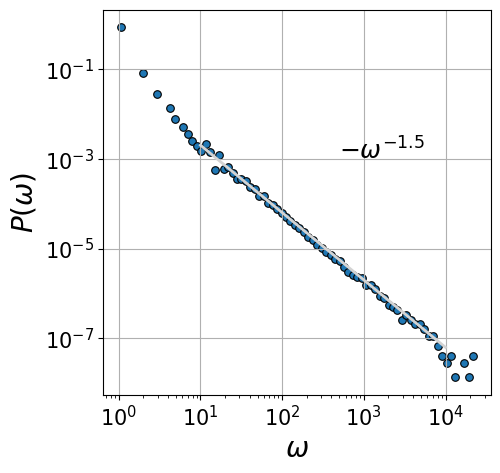

In [55]:
fig = plt.figure()

def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    
    n, bins = np.histogram(x, bins=logbins, weights = np.ones(len(x)) / len(x))
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
    plt.scatter(bins_mean, n, s = 30, edgecolor = 'k', linewidths = 0.8)
    
fig = plt.figure(figsize=(5, 5))
plt.xlabel('$\omega$', fontsize = 20); plt.ylabel('$P(\omega)$', fontsize = 20)
plt.xticks(fontsize = 15); plt.yticks(fontsize = 15)
plt.xscale('log'); plt.yscale('log')

plot_loghist(weight_original, bins = 80)

x = np.array([1, 2, 3, 4]); y = -1.5*x - 1.2
x = 10**x; y = float(10)**y
plt.plot(x, y, linewidth = 2, c = 'lightgray')
plt.text(500, 0.001, r"$-\omega^{-1.5}$", fontsize = 18)

plt.grid(); plt.rc('axes', axisbelow = True)
fig.savefig('figures/SM_fig1a.png', dpi=400, bbox_inches = 'tight')

# 3. Backbone Analysis

Here, we present the distribution of statistical significance values $\alpha_{ij}$ ($\S3.1$), the size of network we retain when choosing different significance level $\alpha$ for thresholding ($\S3.2$), and the topological structure retained across different thresholds $\alpha$ ($\S3.3$). Finally in $\S3.4$, we provide a comparison with the global threshold backbone, where we investigate to what extent the edges of largest weight are retained by the disparity filter. 

In [59]:
global results_dict_values
results_dict_values = np.array(list(results_dict.values()))

## 3.1. $\alpha$: OUT vs IN

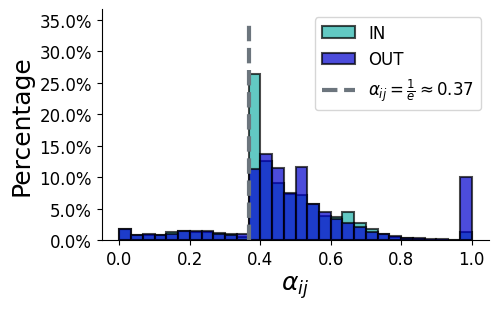

In [238]:
from matplotlib.ticker import PercentFormatter

fig, axs = plt.subplots(figsize=(5, 3))

plt.hist(results_dict_values[:, 3], weights = np.ones(len(results_dict_values[:, 3])) / len(results_dict_values[:, 3]), bins = 30, alpha = 0.7, linewidth = 1.5, edgecolor='black', label = "IN", color = 'lightseagreen')
plt.hist(results_dict_values[:, 2], weights = np.ones(len(results_dict_values[:, 2])) / len(results_dict_values[:, 2]), bins = 30, alpha = 0.7, linewidth = 1.5, edgecolor='black', label = "OUT", color = 'mediumblue') 

# special alpha
y_values = np.arange(0, 0.4, 0.05)
x_values = np.full_like(y_values, 1/np.exp(1))
plt.plot(x_values, y_values, label = r'$\alpha_{ij} = \frac{1}{e} \approx 0.37$', linestyle='--', color = '#6c757d', linewidth = 3)

plt.xlabel(r'$\alpha_{ij}$', fontsize = 18);
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

plt.legend(fontsize = 12)

- Zoom-in

In [169]:
def plot_loghist(x, bins, color, label):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]+10**(-10)),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, weights = np.ones(len(x))/len(results_dict_values[:, 3]), alpha = 0.7, linewidth = 1.5, edgecolor='black', label = label, color = color)

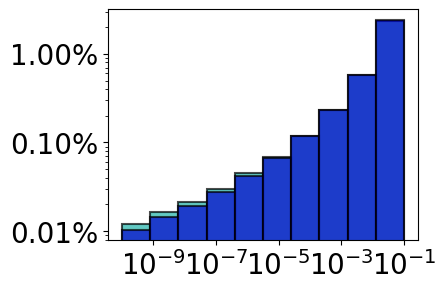

In [181]:
from matplotlib.ticker import PercentFormatter

fig, axs = plt.subplots(figsize=(4, 3))

alpha_ij_in = results_dict_values[:, 3]
index_in = alpha_ij_in < 0.1
alpha_ij_out = results_dict_values[:, 2]
index_out = alpha_ij_out < 0.1

plot_loghist(alpha_ij_in[index_in], bins = 10, color = 'lightseagreen', label = "IN")
plot_loghist(alpha_ij_out[index_out], bins = 10, color = 'mediumblue', label = "OUT")

plt.xscale('log'); plt.yscale('log')
#plt.xlabel(r'$\alpha_{ij}$', fontsize = 18); plt.ylabel('Percentage', fontsize = 18)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#plt.legend(fontsize = 12)

## 3.2. $\alpha$ - %$W_T$, %$N_T$, %$E_T$

In [62]:
def index_retain_alpha(alpha, mode):
    OUT_retain = results_dict_values[:, 2] < alpha
    IN_retain = results_dict_values[:, 3] < alpha
    
    if mode == "OUT":
        index_retain = OUT_retain
    elif mode == "IN":
        index_retain = IN_retain
    else:
        index_retain = np.logical_or(OUT_retain, IN_retain)
    
    return index_retain

In [63]:
weight_dict = nx.get_edge_attributes(G_original, 'weight')
weight_arr = np.array(list(weight_dict.values()))
weight_sum = np.sum(weight_arr)

In [64]:
list(results_dict.keys()) == list(weight_dict.keys())

True

In [65]:
all_edges_arr = np.array(list(weight_dict.keys()))
all_nodes_num = len(np.unique(all_edges_arr))

In [66]:
def percent_alpha(mode, alpha):
    index_retain = index_retain_alpha(alpha, mode)
    
    weight_percent = np.sum(weight_arr[index_retain])/weight_sum
    edge_percent = np.sum(index_retain)/len(index_retain) 
    node_percent = len(np.unique(all_edges_arr[index_retain]))/all_nodes_num
    
    return [weight_percent, node_percent, edge_percent]

### 3.2.1. 0 < $\alpha$ < 1

In [67]:
alpha_arr = np.array([10**(-i-1) for i in range(10)] + list(np.linspace(0.35, 0.45, 40))+ list(np.linspace(0, 1, 50)))

In [68]:
from functools import partial
percent_alpha_or = partial(percent_alpha, "or")

In [69]:
percent_alpha_list_or = p_map(percent_alpha_or, alpha_arr)

  0%|          | 0/100 [00:00<?, ?it/s]

In [70]:
percent_alpha("or", 0.05)

[0.26381054333417486, 0.055028982677929036, 0.029939333545937103]

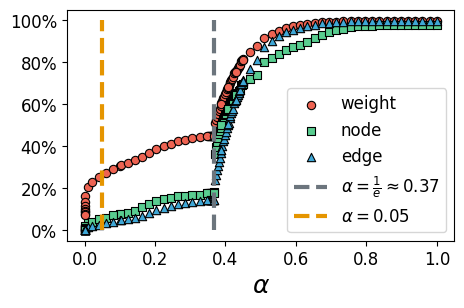

In [72]:
from matplotlib.ticker import PercentFormatter

# Generate y values
weight_percent_arr = np.array(percent_alpha_list_or)[:, 0]
node_percent_arr = np.array(percent_alpha_list_or)[:, 1]
edge_percent_arr = np.array(percent_alpha_list_or)[:, 2]

fig = plt.figure(figsize=(5, 3))

plt.scatter(alpha_arr, weight_percent_arr, linewidth = 0.8, color = '#ee6352', edgecolor = 'k', label = 'weight')
plt.scatter(alpha_arr, node_percent_arr, linewidth = 0.8, marker = 's', color = '#59cd90', edgecolor = 'k', label = 'node')
plt.scatter(alpha_arr, edge_percent_arr, linewidth = 0.8, marker = '^',color = '#3fa7d6', edgecolor = 'k', label = 'edge')

y_values = np.arange(0, 1.1, 0.1)
x_values = np.full_like(y_values, 1/np.exp(1))
plt.plot(x_values, y_values, label = r'$\alpha = \frac{1}{e} \approx 0.37$', linestyle='--', color = '#6c757d', linewidth = 3)

x_values = np.full_like(y_values, 0.05)
plt.plot(x_values, y_values, label = r'$\alpha = 0.05$', linestyle='--', color = '#e59500', linewidth = 3)

plt.xlabel(r'$\alpha$', fontsize = 18);
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.legend(fontsize = 12, loc = 4)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.show()
fig.savefig('figures/SM_fig2.png', dpi=400, bbox_inches = 'tight')

### 3.2.2. 0.35 <  𝛼 < 0.4

In [515]:
alpha_arr = np.linspace(0.365, 0.375, 100)

In [516]:
percent_alpha_list_or = p_map(percent_alpha_or, alpha_arr)

  0%|          | 0/100 [00:00<?, ?it/s]

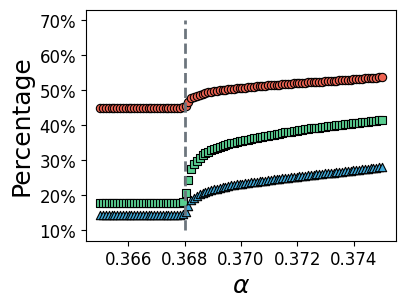

In [518]:
# Generate y values
weight_percent_arr = np.array(percent_alpha_list_or)[:, 0]
node_percent_arr = np.array(percent_alpha_list_or)[:, 1]
edge_percent_arr = np.array(percent_alpha_list_or)[:, 2]

fig = plt.figure(figsize=(4, 3))

plt.scatter(alpha_arr, weight_percent_arr, linewidth = 0.8, color = '#ee6352', edgecolor = 'k', label = 'weight')
plt.scatter(alpha_arr, node_percent_arr, linewidth = 0.8, marker = 's', color = '#59cd90', edgecolor = 'k', label = 'node')
plt.scatter(alpha_arr, edge_percent_arr, linewidth = 0.8, marker = '^',color = '#3fa7d6', edgecolor = 'k', label = 'edge')

# special alpha
y_values = np.arange(0.1, 0.8, 0.1)
x_values = np.full_like(y_values, 0.368)
plt.plot(x_values, y_values, label = r'$\alpha = 0.368$', linestyle='--', color = '#6c757d', linewidth = 2)

plt.xlabel(r'$\alpha$', fontsize = 18); plt.ylabel('Percentage', fontsize = 18)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
#plt.legend(fontsize = 9)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

### 3.2.3. $10^{-10}$ <  𝛼 < $10^{-1}$

In [240]:
alpha_arr = np.array([10**(-0.1*i-1) for i in range(90)])

In [241]:
percent_alpha_list_or = p_map(percent_alpha_or, alpha_arr)

  0%|          | 0/90 [00:00<?, ?it/s]

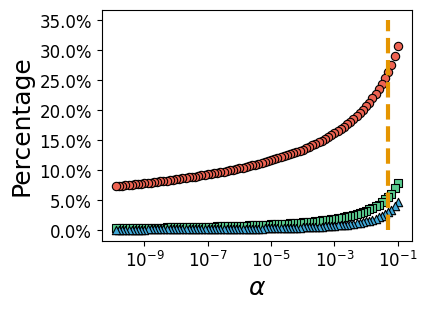

In [243]:
# Generate y values
weight_percent_arr = np.array(percent_alpha_list_or)[:, 0]
node_percent_arr = np.array(percent_alpha_list_or)[:, 1]
edge_percent_arr = np.array(percent_alpha_list_or)[:, 2]

fig = plt.figure(figsize=(4, 3))

plt.scatter(alpha_arr, weight_percent_arr, linewidth = 0.8, color = '#ee6352', edgecolor = 'k', label = 'weight')
plt.scatter(alpha_arr, node_percent_arr, linewidth = 0.8, marker = 's', color = '#59cd90', edgecolor = 'k', label = 'node')
plt.scatter(alpha_arr, edge_percent_arr, linewidth = 0.8, marker = '^',color = '#3fa7d6', edgecolor = 'k', label = 'edge')

# special alpha
y_values = np.arange(0, 0.37, 0.05)
x_values = np.full_like(y_values, 0.05)
plt.plot(x_values, y_values, label = r'$\alpha = 0.05$', linestyle='--', color = '#e59500', linewidth = 3)

plt.xscale('log'); #plt.yscale('log')
plt.xlabel(r'$\alpha$', fontsize = 18); plt.ylabel('Percentage', fontsize = 18)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
#plt.legend(fontsize = 12)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

### 3.2.4. $\alpha = 0$

In [608]:
def index_retain_0(mode):
    OUT_retain = results_dict_values[:, 2] == 0
    IN_retain = results_dict_values[:, 3] == 0
    
    if mode == "OUT":
        index_retain = OUT_retain
    elif mode == "IN":
        index_retain = IN_retain
    else:
        index_retain = np.logical_or(OUT_retain, IN_retain)
    
    return index_retain

In [612]:
def percent_0(mode):
    index_retain = index_retain_0(mode)
    
    weight_percent = np.sum(weight_arr[index_retain])/weight_sum
    edge_percent = np.sum(index_retain)/len(index_retain) 
    node_percent = len(np.unique(all_edges_arr[index_retain]))/all_nodes_num
    
    return [weight_percent, node_percent, edge_percent], [np.sum(weight_arr[index_retain]), len(np.unique(all_edges_arr[index_retain])), np.sum(index_retain)]

In [613]:
percent_0("or")

([0.0053421864430782924, 1.1901212195817383e-05, 2.1567296247842076e-06],
 [607327, 166, 156])

## 3.3. Topological Properties

### 3.3.1. Weight distribution

In [73]:
def weight_alpha(alpha):
    index_retain = index_retain_alpha(alpha, "or")
    
    return weight_arr[index_retain]

In [74]:
alpha_arr = np.array([1, 0.5, 0.4, 0.367, 0.3, 0.1, 0.05, 10**(-2), 10**(-5), 10**(-10)])

In [75]:
weight_retain_list = p_map(weight_alpha, alpha_arr)

  0%|          | 0/10 [00:00<?, ?it/s]

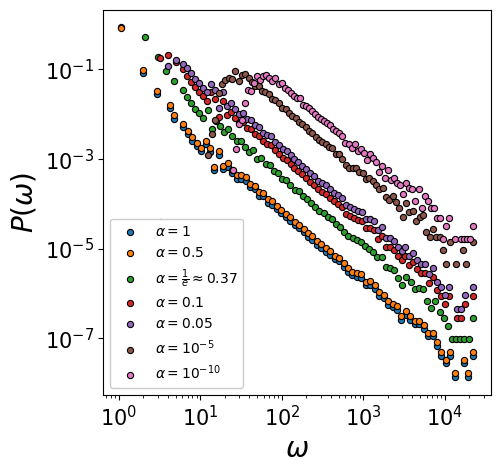

In [76]:
def plot_loghist(x, bins, alpha, part_label):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    
    n, bins = np.histogram(x, bins=logbins, weights = np.ones(len(x)) / len(x))
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
    plt.scatter(bins_mean, n, s = 20, label = r'$\alpha = $' + part_label, edgecolor = 'k', linewidths = 0.8)
    
    
fig = plt.figure(figsize=(5, 5))
plt.xlabel('$\omega$', fontsize = 20); plt.ylabel('$P(\omega)$', fontsize = 20)
plt.xticks(fontsize = 15); plt.yticks(fontsize = 15)
plt.xscale('log'); plt.yscale('log')

part_label_list = [r'1', r'0.5', r'0.4', r'$\frac{1}{e} \approx 0.37$', r'0.3', r'0.1', r'0.05', r'$10^{-2}$', r'$10^{-5}$', r'$10^{-10}$']
for i in range(len(alpha_arr)):
    if i in [0, 1, 3, 5, 6, 8, 9]:
        plot_loghist(weight_retain_list[i], 80, alpha_arr[i], part_label_list[i])

legend = plt.legend()
legend.get_frame().set_alpha(1) 
fig.savefig('figures/SM_fig3b.png', dpi=400, bbox_inches = 'tight')

### 3.3.2. Cumulative degree distribution

#### In-degree

In [77]:
global alpha_results_arr

alpha_results_arr = np.array(list(results_dict.values()))

In [78]:
from itertools import compress

def filtered_network_indegree(alpha):
    
    st = time.time()
    
    remove_index = np.logical_and(results_dict_values[:, 2] >= alpha, results_dict_values[:, 3] >= alpha)
    remove_edges_list = list(compress(edge_list, remove_index))
    
    G = G_real.copy()
    G.remove_edges_from(remove_edges_list)
    G_nodes = np.unique(all_edges_arr[~np.array(remove_index)])
    
    in_degree_dict = dict(G.in_degree())
    in_degree_dict = {node: in_degree_dict[node] for node in G_nodes}
    
    save_address = 'results/indegree_node_dict_alpha' + str(alpha) + '.pkl'
    with open(save_address, 'wb') as pickle_file:
        pickle.dump(in_degree_dict, pickle_file)
    
    et = time.time()
    elapsed_time = et - st
    
    print('Execution time:', elapsed_time/60, 'mins')
    # Getting % usage of virtual_memory ( 3rd field)
    print('RAM memory % used:', psutil.virtual_memory()[2])
    # Getting usage of virtual_memory in GB ( 4th field)
    print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
    print("==========")

In [79]:
alpha_arr = np.array([1, 0.5, 0.367, 0.1, 0.05, 10**(-5), 10**(-10)])

In [21]:
for alpha in alpha_arr:
    print(alpha)
    filtered_network_indegree(alpha)

1.0
Execution time: 6.301191329956055 mins
RAM memory % used: 33.9
RAM Used (GB): 133.89449216
0.5
Execution time: 5.1946611682573955 mins
RAM memory % used: 42.3
RAM Used (GB): 167.834775552
0.367
Execution time: 9.730204598108928 mins
RAM memory % used: 37.8
RAM Used (GB): 149.819138048
0.1
Execution time: 8.790443054835002 mins
RAM memory % used: 37.3
RAM Used (GB): 147.602558976
0.05
Execution time: 6.575226859251658 mins
RAM memory % used: 38.2
RAM Used (GB): 151.292141568
1e-05
Execution time: 8.874284223715465 mins
RAM memory % used: 38.7
RAM Used (GB): 153.363304448
1e-10
Execution time: 8.719510746002197 mins
RAM memory % used: 37.9
RAM Used (GB): 150.395650048


- Load Results

In [80]:
alpha_arr = np.array([1, 0.5, 0.367, 0.1, 0.05, 10**(-5), 10**(-10)])

In [81]:
def plot_ccdf(degree, part_label):
    
    degree_freq = np.bincount(degree)
    x = np.array(range(len(degree_freq))) + 1
    y = 1 - np.cumsum(degree_freq/np.sum(degree_freq))
    
    plot_index = np.array([i for i in range(10)] + [10**(5/100 * (i) + 1) for i in range(100) if 10**(5/100 * (i) + 1) < len(x)]).astype(int)
    
    plt.scatter(x[plot_index], y[plot_index], s = 20, label = r'$\alpha = $' + part_label, edgecolor = 'k', linewidths = 0.8)

In [82]:
part_label_list = [r'1', r'0.5', r'$\frac{1}{e} \approx 0.37$', r'0.1', r'0.05', r'$10^{-5}$', r'$10^{-10}$']

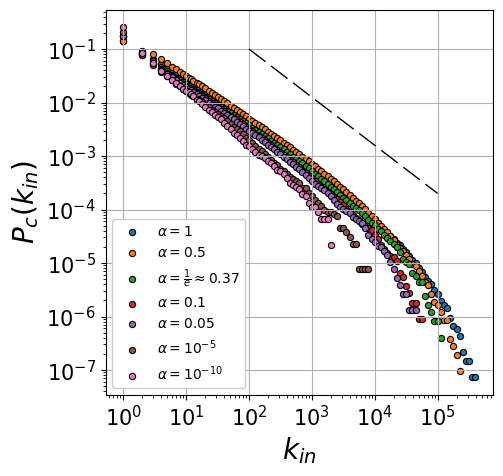

In [83]:
fig, axs = plt.subplots(figsize=(5,5))

i = 0
for alpha in alpha_arr:
    
    save_address = 'results/indegree_node_dict_alpha' + str(alpha) + '.pkl'
    with open(save_address, 'rb') as pickle_file:
        in_degree_dict = pickle.load(pickle_file)
        
    in_degree = list(in_degree_dict.values())
    plot_ccdf(in_degree, part_label = part_label_list[i])
    
    i += 1

x = np.array([2, 3, 4, 5]); y = -0.9*x + 0.8
x = 10**x; y = 10**y
plt.plot(x, y, linestyle = '--', linewidth = 1, c = 'k', dashes=[15, 5, 15, 5])

plt.xlabel(r'$k_{in}$', fontsize = 20); plt.ylabel(r'$P_c(k_{in})$', fontsize = 20)
plt.xticks(fontsize = 15); plt.yticks(fontsize = 15)
plt.xscale('log'); plt.yscale('log') 
legend = plt.legend(loc = "lower left"); legend.get_frame().set_alpha(1) 
plt.grid(); plt.rc('axes', axisbelow=True)
fig.savefig('figures/SM_fig3c.png', dpi=400, bbox_inches = 'tight')

#### Out-degree

In [84]:
from itertools import compress
def filtered_network_outdegree(alpha):
    
    st = time.time()
    
    remove_index = np.logical_and(results_dict_values[:, 2] >= alpha, results_dict_values[:, 3] >= alpha)
    remove_edges_list = list(compress(edge_list, remove_index))
    
    G = G_real.copy()
    G.remove_edges_from(remove_edges_list)
    G_nodes = np.unique(all_edges_arr[~np.array(remove_index)])
    
    out_degree_dict = dict(G.out_degree())
    out_degree_dict = {node: out_degree_dict[node] for node in G_nodes}
    
    save_address = 'results/outdegree_node_dict_alpha' + str(alpha) + '.pkl'
    with open(save_address, 'wb') as pickle_file:
        pickle.dump(out_degree_dict, pickle_file)
    
    et = time.time()
    elapsed_time = et - st
    
    print('Execution time:', elapsed_time/60, 'mins')
    # Getting % usage of virtual_memory ( 3rd field)
    print('RAM memory % used:', psutil.virtual_memory()[2])
    # Getting usage of virtual_memory in GB ( 4th field)
    print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
    print("==========")

In [23]:
for alpha in alpha_arr:
    print(alpha)
    filtered_network_outdegree(alpha)

1.0
Execution time: 5.083326689402262 mins
RAM memory % used: 38.2
RAM Used (GB): 151.266852864
0.5
Execution time: 8.126857535044353 mins
RAM memory % used: 39.1
RAM Used (GB): 154.970075136
0.367
Execution time: 9.131854498386383 mins
RAM memory % used: 41.2
RAM Used (GB): 163.454787584
0.1
Execution time: 6.663136394818624 mins
RAM memory % used: 41.2
RAM Used (GB): 163.41755904
0.05
Execution time: 9.254641167322795 mins
RAM memory % used: 41.0
RAM Used (GB): 162.610221056
1e-05
Execution time: 6.73941019376119 mins
RAM memory % used: 41.0
RAM Used (GB): 162.66473472
1e-10
Execution time: 8.950478971004486 mins
RAM memory % used: 39.9
RAM Used (GB): 158.22282752


- Load Results

In [85]:
alpha_arr = np.array([1, 0.5, 0.367, 0.1, 0.05, 10**(-5), 10**(-10)])

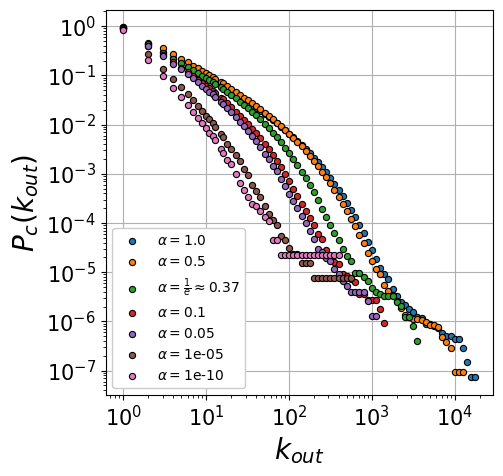

In [86]:
fig, axs = plt.subplots(figsize=(5,5))

for alpha in alpha_arr:
    
    save_address = 'results/outdegree_node_dict_alpha' + str(alpha) + '.pkl'
    with open(save_address, 'rb') as pickle_file:
        out_degree_dict = pickle.load(pickle_file)
        
    out_degree = list(out_degree_dict.values())
    if alpha == 0.367:
        plot_ccdf(out_degree, part_label = r'$\frac{1}{e} \approx 0.37$')
    else:
        plot_ccdf(out_degree, part_label = str(alpha))

#x = np.array([3, 4]); y = -2.2*x + 4.8
#x = 10**x; y = float(10)**y
#plt.plot(x, y, linestyle = '--', linewidth = 1, c = 'k', dashes=[15, 5, 15, 5])

plt.xlabel(r'$k_{out}$', fontsize = 20); plt.ylabel(r'$P_c(k_{out})$', fontsize = 20)
plt.xticks(fontsize = 15); plt.yticks(fontsize = 15)
plt.xscale('log'); plt.yscale('log') 
legend = plt.legend(loc = "lower left"); legend.get_frame().set_alpha(1) 
plt.grid(); plt.rc('axes', axisbelow=True)
fig.savefig('figures/SM_fig3d.png', dpi=400, bbox_inches = 'tight')

### 3.3.3. Clustering Coefficient (key to determine $\alpha$)

In [99]:
edge_list = list(results_dict.keys())
all_edges_arr = np.array(list(results_dict.keys()))
alpha_results_arr = np.array(list(results_dict.values()))

In [113]:
bool_arr = [True, True, True, False, True]

if all(bool_arr):
    print("All are True")
else:
    print("At least one is False")

At least one is False


In [114]:
from itertools import compress

def filtered_network_clustering(alpha):
    print("alpha: ", alpha)
    
    st = time.time()
    
    # check if file already exist
    bool_arr = []
    for i in range(10):
        save_address = 'Results/clustering_coeff_node_dict_alpha' + str(alpha) + '_index' + str(i) + '.pkl'
        bool_arr.append(os.path.exists(save_address))
    if all(bool_arr):
        print("All results generated already.")
    # if not exist
    else:
        remove_index = np.logical_and(alpha_results_arr[:, 2] >= alpha, alpha_results_arr[:, 3] >= alpha)
        remove_edges_list = list(compress(edge_list, remove_index))
    
        G = G_original.copy()
        G.remove_edges_from(remove_edges_list)
        G.remove_nodes_from(list(nx.isolates(G)))
    
        more_than_one_degree_index = (np.array(list(dict(G.degree()).values())) > 1)
        separate_node_list = list(split_list(np.array(list(G.nodes))[more_than_one_degree_index], 10))
    
        for i in range(10):
            print("index: " + str(i), end=' ')
            save_address = 'results/clustering_coeff_node_dict_alpha' + str(alpha) + '_index' + str(i) + '.pkl'
            if os.path.exists(save_address):
                print("File exists.")
            else:
                clustering_coeff_dict = nx.clustering(G, nodes = separate_node_list[i], weight = None)
                with open(save_address, 'wb') as pickle_file:
                    pickle.dump(clustering_coeff_dict, pickle_file)
    
    et = time.time()
    elapsed_time = et - st

    print('Execution time:', elapsed_time/60, 'mins')
    # Getting % usage of virtual_memory ( 3rd field)
    print('RAM memory % used:', psutil.virtual_memory()[2])
    # Getting usage of virtual_memory in GB ( 4th field)
    print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
    print("==========")

In [116]:
for alpha in [10**(-i-1) for i in range(9)] + [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] + [0.05]:
    filtered_network_clustering(alpha)

alpha:  0.1
All results generated already.
Execution time: 1.1225541432698568e-05 mins
RAM memory % used: 34.3
RAM Used (GB): 135.543361536
alpha:  0.01
All results generated already.
Execution time: 8.066495259602865e-07 mins
RAM memory % used: 34.3
RAM Used (GB): 135.543361536
alpha:  0.001
All results generated already.
Execution time: 7.867813110351562e-07 mins
RAM memory % used: 34.3
RAM Used (GB): 135.543361536
alpha:  0.0001
All results generated already.
Execution time: 7.62939453125e-07 mins
RAM memory % used: 34.3
RAM Used (GB): 135.543361536
alpha:  1e-05
All results generated already.
Execution time: 8.106231689453125e-07 mins
RAM memory % used: 34.3
RAM Used (GB): 135.543361536
alpha:  1e-06
All results generated already.
Execution time: 7.708867390950521e-07 mins
RAM memory % used: 34.3
RAM Used (GB): 135.543361536
alpha:  1e-07
All results generated already.
Execution time: 8.026758829752604e-07 mins
RAM memory % used: 34.3
RAM Used (GB): 135.543361536
alpha:  1e-08
All 

- Load results

In [135]:
def clustering_avg(clustering_dict):
    clustering_arr = np.array(list(clustering_dict.values()))
    return np.average(clustering_arr)

In [132]:
def load_filtered_network_clustering(alpha):
    
    clustering_coeff_dict = {}
    
    for i in range(10):
        save_address = 'results/clustering_coeff_node_dict_alpha' + str(alpha) + '_index' + str(i) + '.pkl'
        with open(save_address, 'rb') as pickle_file:
            clustering_coeff_dict.update(pickle.load(pickle_file))
    
    return clustering_coeff_dict

In [133]:
alpha_avg_clustering_coeff_dict = {}
for alpha in [10**(-i-1) for i in range(9)] + [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] + [0.05]:
    clustering_coeff = clustering_avg(load_filtered_network_clustering(alpha))
    alpha_avg_clustering_coeff_dict.update({alpha: clustering_coeff})

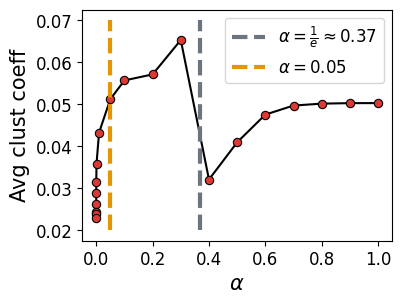

In [140]:
fig, axs = plt.subplots(figsize=(4,3))

x = list(alpha_avg_clustering_coeff_dict.keys()); x.sort()
y = [alpha_avg_clustering_coeff_dict[element] for element in x]

plt.scatter(list(alpha_avg_clustering_coeff_dict.keys()), list(alpha_avg_clustering_coeff_dict.values()), c = "#db3a34", edgecolor = 'k', linewidths = 0.8, zorder = 2)
plt.plot(x, y, c = 'k', zorder = 1)

y_values = np.arange(0.02, 0.075, 0.005)
x_values = np.full_like(y_values, 1/np.exp(1))
plt.plot(x_values, y_values, label = r'$\alpha = \frac{1}{e} \approx 0.37$', linestyle='--', color = '#6c757d', linewidth = 3)

x_values = np.full_like(y_values, 0.05)
plt.plot(x_values, y_values, label = r'$\alpha = 0.05$', linestyle='--', color = '#e59500', linewidth = 3)

plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.xlabel(r"$\alpha$", fontsize = 15); plt.ylabel("Avg clust coeff", fontsize = 15)
plt.legend(fontsize = 12)
fig.savefig('figures/SM_fig3a.png', dpi=400, bbox_inches = 'tight')

## 3.4. Largest Weight Captured

In [144]:
import scipy.stats as ss
def rank_percentage(arr):
    
    ranks = ss.rankdata(arr)
    percentages = (ranks / len(arr))
    
    return percentages

In [145]:
weight_arr_percentage = rank_percentage(weight_arr)

In [141]:
def joint_percent_cal(alpha, top_weight_percent):
    weight_index = weight_arr_percentage > 1 - top_weight_percent
    
    backbone_index = index_retain_alpha(alpha, mode = 'or')
    joint_index = np.logical_and(weight_index, backbone_index)
    
    joint_percent = np.sum(joint_index)/np.sum(weight_index)
    
    return joint_percent

In [146]:
alpha_arr = [1, 1/np.exp(1), 0.05] + [10**(-i-2) for i in range(8)]

In [147]:
y1 = [joint_percent_cal(alpha, 0.05) for alpha in alpha_arr]
y2 = [joint_percent_cal(alpha, 0.01) for alpha in alpha_arr]
y3 = [joint_percent_cal(alpha, 0.001) for alpha in alpha_arr]

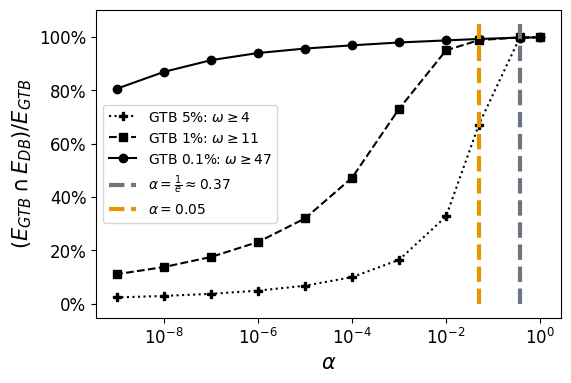

In [149]:
fig, axs = plt.subplots(figsize=(6,4))

plt.plot(alpha_arr, y1, marker = 'P', c = 'k', linestyle = ':', label = r'GTB 5%: $\omega \geq 4$')
plt.plot(alpha_arr, y2, marker = 's', linestyle = '--'  ,c = 'k', label = r'GTB 1%: $\omega \geq 11$')
plt.plot(alpha_arr, y3, marker = 'o', c = 'k', label = r'GTB 0.1%: $\omega \geq 47$')

y_values = np.arange(0, 1.1, 0.05)
x_values = np.full_like(y_values, 1/np.exp(1))
plt.plot(x_values, y_values, label = r'$\alpha = \frac{1}{e} \approx 0.37$', linestyle='--', color = '#6c757d', linewidth = 3)

x_values = np.full_like(y_values, 0.05)
plt.plot(x_values, y_values, label = r'$\alpha = 0.05$', linestyle='--', color = '#e59500', linewidth = 3)

plt.xscale('log')
plt.xlabel(r'$\alpha$', fontsize = 15); plt.ylabel(r'$(E_{GTB} \cap E_{DB}) / E_{GTB}$', fontsize = 15)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.legend(fontsize = 10)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
fig.savefig('figures/SM_fig4.png', dpi=400, bbox_inches = 'tight')

# 4. Save Filtered Network

In [150]:
def filtered_network(alpha):
    st = time.time()
    
    remove_index = np.logical_and(alpha_results_arr[:, 2] >= alpha, alpha_results_arr[:, 3] >= alpha)
    remove_edges_list = list(compress(edge_list, remove_index))
    
    G = G_original.copy()
    G.remove_edges_from(remove_edges_list)
    G.remove_nodes_from(list(nx.isolates(G)))
    
    et = time.time()
    elapsed_time = et - st
    
    return G

In [153]:
st = time.time()

alpha = 0.05
G_filtered = filtered_network(alpha)
nx.write_gpickle(G_filtered, "Data/Graphs/G_filtered.gpickle")

et = time.time()
elapsed_time = et - st

print('Execution time:', elapsed_time/60, 'mins')
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

Execution time: 6.244124905268351 mins
RAM memory % used: 46.0
RAM Used (GB): 182.727602176


In [154]:
nx.info(G_filtered)

'DiGraph with 767553 nodes and 2165564 edges'